# MLE for Poisson Distribution

In this notebook you will perform [maximum likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood), or MLE, for the parameter $\lambda$ in the [Poisson](https://en.wikipedia.org/wiki/Poisson_distribution) distribution and bootstrap the results.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from scipy.optimize import minimize
from scipy.stats import poisson

In [3]:
import tensorflow as tf
from tensorflow.contrib import distributions as dist

## Create a dataset

Generate a dataset from the Poisson distribution with a known parameter $\lambda$:

In [4]:
np.random.seed(0)
λ = 3.0
data = np.random.poisson(λ, size=20)

## MLE with Tensorflow

Use TensorFlow to write a function that performs MLE for the $\lambda$ parameter of the Poisson distribution. In your function you should:

* Create all of the needed TensorFlow `Variable` and `placeholder` instances.
* Create an initialize a `Session`.
* Call `Session.close()` before returning your estimate for lambda (you can also create and use the `Session` with Python's `with` statement).
* Use the `float32` dtype.
* Play with the learning parameter and number of gradient descent steps to get the function to run quickly and give results that are accurate enough to pass the tests.

In [5]:
def fit_lambda(data):
    """Perform MLE to estimate the λ parameter of the Poisson distribution.
    
    Parameters
    ----------
    data: ndarray
        The data to use in estimating lambda
    
    Returns
    -------
    lambda: float
        The MLE value for lambda
    """
    lam = tf.Variable(data.mean(), dtype=tf.float32)
    x = tf.placeholder(dtype=tf.float32)
    size = tf.placeholder(dtype=tf.float32)
    model = dist.Poisson(lam=lam)
    nll = -1.0 * (tf.reduce_sum(x * tf.log(lam)) - size * lam)
    
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        optimizer = tf.train.GradientDescentOptimizer(0.001)
        train = optimizer.minimize(nll)
        for i in range(1000):
            sess.run(train, {x: data, size: len(data)})
        return sess.run(lam) 

In [6]:
assert abs(fit_lambda(3*np.ones(10))-3.0) < 1e-3
assert abs(fit_lambda(100*np.ones(100))-100.0) < 1e-3
assert abs(fit_lambda(data)-data.mean()) < 1e-3

Here is the MLE for lambda given our original data:

In [7]:
fit_lambda(data)

2.9000001

And the time for a single fit:

In [8]:
%timeit -n1 -r1 fit_lambda(data)

1 loop, best of 1: 389 ms per loop


## MLE with `scipy.optimize.minimize`

Use SciPy, write a function that performs MLE for the $\lambda$ parameter of the Poisson distribution. In your function you should:

* Use `scipy.stats.poisson` to calculate the negative log-likelihood of the Poisson distribution.
* Use `scipy.optimize.minimize` to minimize the negative log-likelihood.

In [9]:
def fit_lambda_fast(data):
    """Perform MLE to estimate the λ parameter of the Poisson distribution.
    
    Parameters
    ----------
    data: ndarray
        The data to use in estimating lambda
    
    Returns
    -------
    lambda: float
        The MLE value for lambda
    """
    to_minimize = lambda theta: -1.0 * (np.sum(data * np.log(theta[0])) - len(data) * theta[0])
    fit = minimize(to_minimize, data.mean())
    return fit.x

In [10]:
assert abs(fit_lambda_fast(3*np.ones(10))-3.0) < 1e-3
assert abs(fit_lambda_fast(100*np.ones(100))-100.0) < 1e-3
assert abs(fit_lambda_fast(data)-data.mean()) < 1e-3

Here is the estimated value of $\lambda$:

In [11]:
fit_lambda_fast(data)

array([ 2.9])

And the timing of a single run, which should be much faster than the TensorFlow result:

In [12]:
%timeit -n1 -r1 fit_lambda_fast(data)

1 loop, best of 1: 204 µs per loop


## Bootstrap

We see that the MLE for $\hat{\lambda}$ is close to the original value of $\lambda=3.0$. Bootstrap resample this estimator 200 times (using your faster version) to find the distribution of $\hat{\lambda}$. Save the distributions of $\lambda$ values in an list or array named `estimates`:

In [13]:
estimates = np.zeros(200)
for idx in range(200):
    estimates[idx] = fit_lambda_fast(np.random.choice(data, size=len(data)))

Plot the distibution of bootstrapped estimates using Matplotlib. Lable your axes, use a grid and customize the bins:

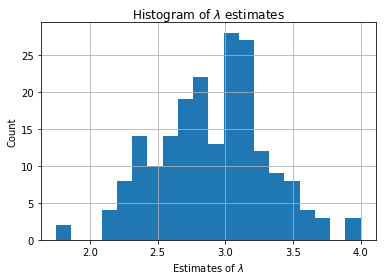

In [14]:
plt.hist(estimates, bins=20)
plt.xlabel('Estimates of $\lambda$')
plt.ylabel('Count')
plt.title('Histogram of $\lambda$ estimates')
plt.grid(True);

Compute the print the 95% confidence interval:

In [15]:
print("95% confidence interval for lambda", np.percentile(estimates, [2.5, 97.5]))

95% confidence interval for lambda [ 2.15  3.7 ]
